<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/7_Fine_CW_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Mon Jun  8 10:19:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_utils_functions import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should 

In [0]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 1e-5 # Learning rate

# Data

In [5]:
!git clone https://github.com/filmerxyz/HAM10000_split

fatal: destination path 'HAM10000_split' already exists and is not an empty directory.


In [0]:
train_path = '/content/HAM10000_split/train' 
val_path = '/content/HAM10000_split/val'
test_path = '/content/HAM10000_split/test'

## Data Augmentation

In [0]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = train_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = train_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None) 

Found 6303 images belonging to 7 classes.
Found 2707 images belonging to 7 classes.
Found 1005 images belonging to 7 classes.


# Class Weights

In [0]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [0]:
class_weights_dict = { i : class_weights[i] for i in range(0, len(class_weights) ) }

# Model

## Build

In [0]:
def build_model():
  base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  base_model.trainable = True

  for layer in base_model.layers[:15]: # Fixed first 15 layers
    layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

  return model

In [12]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Compile

In [0]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='7_fine_cw_vgg16_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [16]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights_dict,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
197/197 [==============================] - 152s 772ms/step - loss: 1.9015 - accuracy: 0.2380 - val_loss: 2.1261 - val_accuracy: 0.0986 - lr: 1.0000e-05
Epoch 2/100
197/197 [==============================] - 145s 738ms/step - loss: 1.6414 - accuracy: 0.2383 - val_loss: 1.9059 - val_accuracy: 0.1389 - lr: 1.0000e-05
Epoch 3/100
197/197 [==============================] - 145s 736ms/step - loss: 1.5316 - accuracy: 0.2888 - val_loss: 1.6474 - val_accuracy: 0.3801 - lr: 1.0000e-05
Epoch 4/100
197/197 [==============================] - 145s 737ms/step - loss: 1.4574 - accuracy: 0.2911 - val_loss: 2.2429 - val_accuracy: 0.1581 - lr: 1.0000e-05
Epoch 5/100
197/197 [==============================] - 145s 734ms/step - loss: 1.3864 - accuracy: 0.3259 - val_loss: 1.8337 - val_accuracy: 0.3136 - lr: 1.0000e-05
Epoch 6/100
197/197 [==============================] - 144s 733ms/step - loss: 1.3440 - accuracy: 0.3327 - val_loss: 1.5415 - val_accuracy: 0.4559 - lr: 1.0000e-05
Epoch 7/100
197/

# Graph

## Accuracy

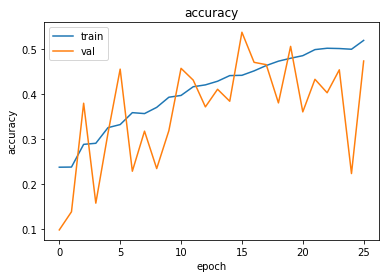

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

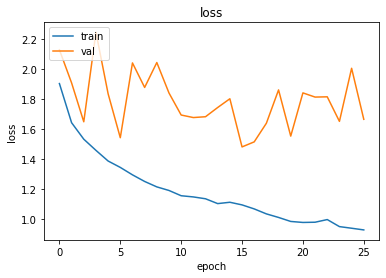

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = tf.keras.models.load_model('/content/7_fine_cw_vgg16_model.h5')

In [0]:
num_test_files = len(test_generator.filenames)

In [0]:
test_generator.reset()

In [0]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

## Confusion Matrix

### Without Normalize

Confusion matrix, without normalization
[[ 27   4   1   0   1   0   0]
 [ 13  37   0   0   0   0   2]
 [ 35   6  47   1  10   9   2]
 [  3   1   0   5   0   3   0]
 [ 17   6  20   1  60   5   3]
 [ 73  48  58  15  98 333  46]
 [  1   0   0   0   0   0  14]]


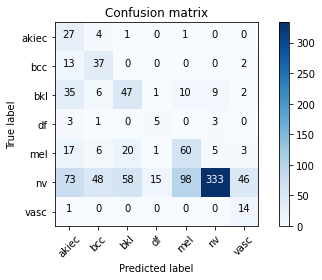

In [23]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.81818182 0.12121212 0.03030303 0.         0.03030303 0.
  0.        ]
 [0.25       0.71153846 0.         0.         0.         0.
  0.03846154]
 [0.31818182 0.05454545 0.42727273 0.00909091 0.09090909 0.08181818
  0.01818182]
 [0.25       0.08333333 0.         0.41666667 0.         0.25
  0.        ]
 [0.15178571 0.05357143 0.17857143 0.00892857 0.53571429 0.04464286
  0.02678571]
 [0.10879285 0.07153502 0.08643815 0.02235469 0.14605067 0.49627422
  0.0685544 ]
 [0.06666667 0.         0.         0.         0.         0.
  0.93333333]]


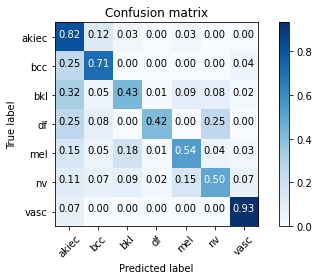

In [24]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [25]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[ 27   4   1   0   1   0   0]
 [ 13  37   0   0   0   0   2]
 [ 35   6  47   1  10   9   2]
 [  3   1   0   5   0   3   0]
 [ 17   6  20   1  60   5   3]
 [ 73  48  58  15  98 333  46]
 [  1   0   0   0   0   0  14]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.16      0.82      0.27        33
         bcc       0.36      0.71      0.48        52
         bkl       0.37      0.43      0.40       110
          df       0.23      0.42      0.29        12
         mel       0.36      0.54      0.43       112
          nv       0.95      0.50      0.65       671
        vasc       0.21      0.93      0.34        15

    accuracy                           0.52      1005
   macro avg       0.38      0.62      0.41      1005
weighted avg       0.75      0.52      0.57      1005



## Sensitivity & Specificity

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [27]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.8710
specificity: 0.7400


# Grad-CAM

In [0]:
last_conv2d = 'block5_conv3'

## AKIEC

In [0]:
akiec_img = '/content/HAM10000_split/train/akiec/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.973
	bkl            	(2)	with probability 0.016
	bcc            	(1)	with probability 0.004
	vasc           	(6)	with probability 0.004
	df             	(3)	with probability 0.003
Explanation for 'mel'


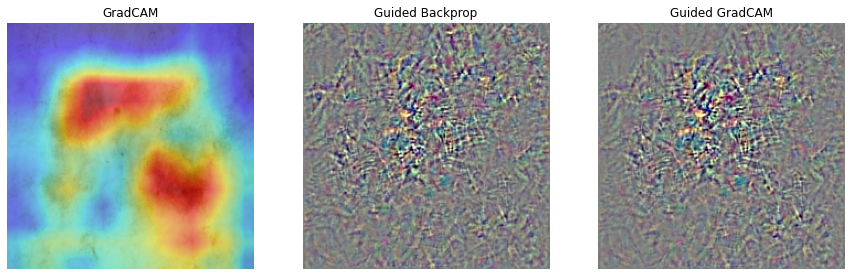

In [30]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

## BCC

In [0]:
bcc_img = '/content/HAM10000_split/train/bcc/ISIC_0024332.jpg'

Model prediction:
	bcc            	(1)	with probability 0.573
	bkl            	(2)	with probability 0.154
	df             	(3)	with probability 0.106
	mel            	(4)	with probability 0.101
	vasc           	(6)	with probability 0.057
Explanation for 'bcc'


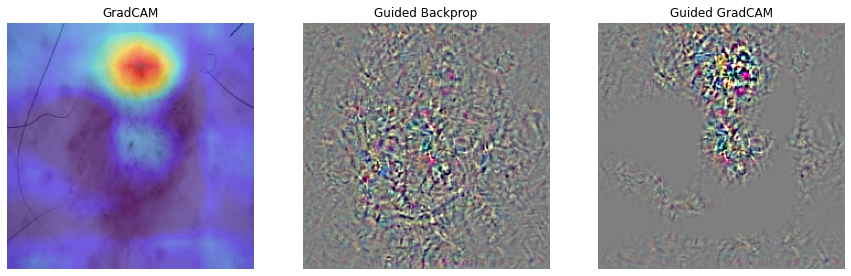

In [32]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

## BKL

In [0]:
bkl_img = '/content/HAM10000_split/train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.968
	bkl            	(2)	with probability 0.025
	vasc           	(6)	with probability 0.006
	bcc            	(1)	with probability 0.002
	df             	(3)	with probability 0.000
Explanation for 'mel'


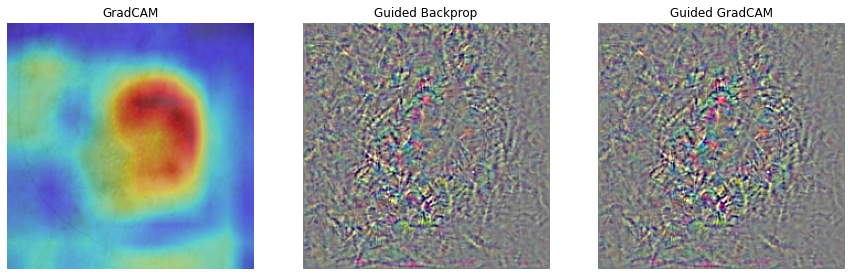

In [34]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

## DF

In [0]:
df_img = '/content/HAM10000_split/val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.851
	df             	(3)	with probability 0.063
	nv             	(5)	with probability 0.031
	bkl            	(2)	with probability 0.021
	vasc           	(6)	with probability 0.018
Explanation for 'mel'


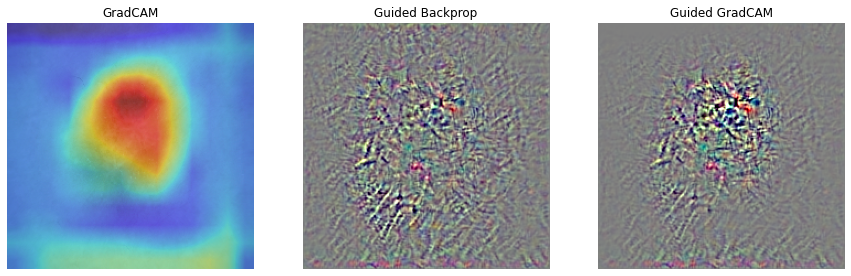

In [36]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

## MEL

In [0]:
mel_img = '/content/HAM10000_split/train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.966
	vasc           	(6)	with probability 0.024
	bkl            	(2)	with probability 0.006
	bcc            	(1)	with probability 0.002
	df             	(3)	with probability 0.002
Explanation for 'mel'


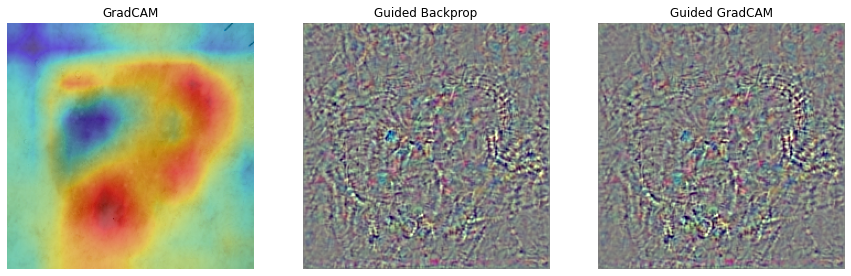

In [38]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

## NV

In [0]:
nv_img = '/content/HAM10000_split/val/nv/ISIC_0024349.jpg'

Model prediction:
	mel            	(4)	with probability 0.917
	vasc           	(6)	with probability 0.066
	bcc            	(1)	with probability 0.010
	bkl            	(2)	with probability 0.004
	df             	(3)	with probability 0.002
Explanation for 'mel'


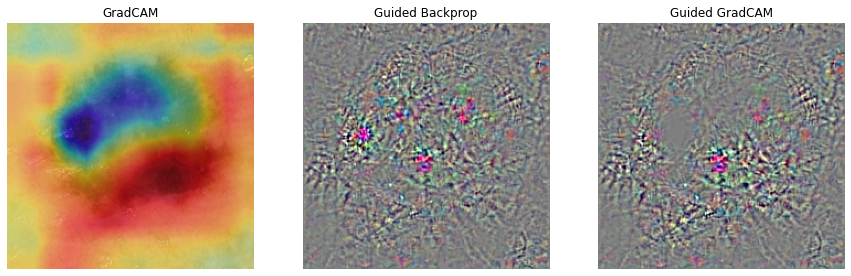

In [40]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

## VASC

In [0]:
vasc_img = '/content/HAM10000_split/test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 1.000
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
	mel            	(4)	with probability 0.000
	nv             	(5)	with probability 0.000
Explanation for 'vasc'


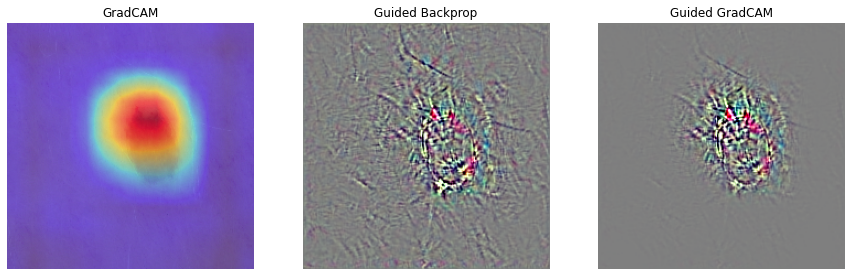

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)